# Time Series Analysis with Python
The purpose of this tutortial is to introduce useful Python functions in the context of a worked example. Electirc consumption data for this tutortial was drawn from single-family homes in Oregon that installed ductless-heat pumps to dislace less efficient electric resistance baseboard heating. This data is combine with weather and project data to develop regression models and estimate energy savings during the first year following the installation of the heat pumps.

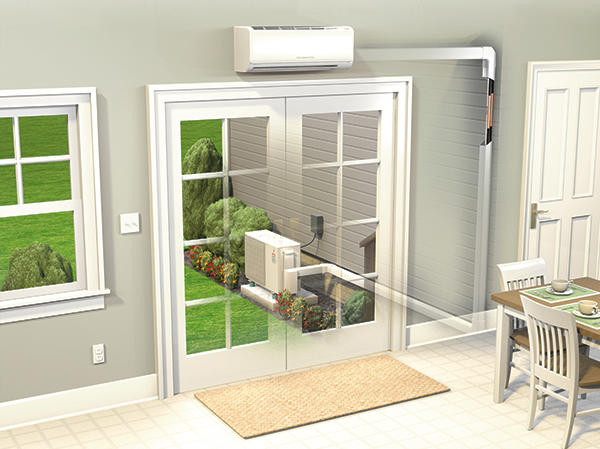

In [1]:
from IPython.display import Image
Image(filename='data/raw/dhp.png') 

The unit of analysis in this example is a home or "site", and each site has a number that is used to identify that sites data across different data sets. 

In [2]:
site_number = '683285'
#site_number = '411894'

## Data Preparation


### Billing Data
One dataset used in this anlaysis contains records of monthly electric usage and is maintained by the local utility for the purpose of billing homeowners for their energy consumption. The raw billing data is provided with several fields that aren't relevant to the analysis and that require some manipulation prior to modeling. The Python module used for this manipulation is called "pandas" and contains many useful functions.

The pandas function "read_csv" is used to import data stored in a .csv file into Python. The data is then stored as a "data frame" (abbreviated as "df") that enables pandas functions to easily be applied to that data. 

In [3]:
import pandas as pd  # import pandas into python and abbreviate as pd

In [4]:
billing_df = pd.read_csv('data/raw/billing data.csv', dtype=str)

Even when working in Python, Excel is useful for reviewing data and figuring out what columns are of interest. pandas also provides functions for viewing data, the .info() function displays the columns labels of the dataset and the number of values in each column.

In [5]:
billing_df.head()

Unnamed: 0     ProjectId et_sitenumber et_parentsitenumber  \
0     207498  P00001111548        411894                 NaN   
1     207499  P00001111548        411894                 NaN   
2     207500  P00001111548        411894                 NaN   
3     207501  P00001111548        411894                 NaN   
4     207502  P00001111548        411894                 NaN   

      et_streetaddress  et_city et_state et_zipplus4 Utility      Fuel  \
0  69539 E Fairway Ave  Welches       OR  97067-8767     PGE  Electric   
1  69539 E Fairway Ave  Welches       OR  97067-8767     PGE  Electric   
2  69539 E Fairway Ave  Welches       OR  97067-8767     PGE  Electric   
3  69539 E Fairway Ave  Welches       OR  97067-8767     PGE  Electric   
4  69539 E Fairway Ave  Welches       OR  97067-8767     PGE  Electric   

        ...             PODID MeterNumber RateCode  \
0       ...         701719279    27151083      711   
1       ...         701719279    27151083      711   
2       ...         701719279    27151083      711   
3       ...         701719279    27151083      711   
4       ...         701719279    27151083      711   

               RateDescription   ETRateType ETReadType   ReadDate   kWh  \
0  07 Residential Electric (1)  Residential     Actual  4/29/2011  2767   
1  07 Residential Electric (1)  Residential     Actual  5/31/2011  2338   
2  07 Residential Electric (1)  Residential     Actual  6/29/2011  1531   
3  07 Residential Electric (1)  Residential     Actual  7/29/2011  1208   
4  07 Residential Electric (1)  Residential     Actual  8/30/2011   935   

  therms DuplicateWarning  
0    NaN                0  
1    NaN                0  
2    NaN                0  
3    NaN                0  
4    NaN                0  

[5 rows x 24 columns]

This example will only use the columns labeled "ReadDate", "et_sitenumber", and "kWh". These are selected below.

In [6]:
billing_df = billing_df[['ReadDate', 'kWh', 'et_sitenumber']]

Select only data associated with a single site.

In [7]:
billing_df = billing_df[billing_df['et_sitenumber'] == site_number]
del billing_df['et_sitenumber']

In [8]:
billing_df.head()

ReadDate   kWh
110  4/29/2011  1534
111  5/31/2011  1126
112  6/29/2011   781
113  7/29/2011   755
114  8/30/2011   899

Both data fields 'ReadDate' and 'kWh' are needed for the analysis and if either is missing from an entry then that row can't be used.

In [9]:
billing_df = billing_df.dropna(how='any')

The values in the column 'ReadDate' are read into Python as text and need to be converted to time stamp data types.

In [10]:
date_format = '%m/%d/%Y'
billing_df['ReadDate'] = pd.to_datetime(billing_df['ReadDate'], format=date_format)

The kWh values were also read in as text and are converted to numeric data below.

In [11]:
billing_df['kWh'] = pd.to_numeric(billing_df['kWh'])

The last step here is to set the time stamps as the index of the data frame.

In [12]:
billing_df = billing_df.set_index('ReadDate')

In [13]:
billing_df.head()

kWh
ReadDate        
2011-04-29  1534
2011-05-31  1126
2011-06-29   781
2011-07-29   755
2011-08-30   899

Using the pandas plot() function and the library matplotlib it is easy to create simple plots of the billing data.

In [14]:
import matplotlib.pyplot as plt

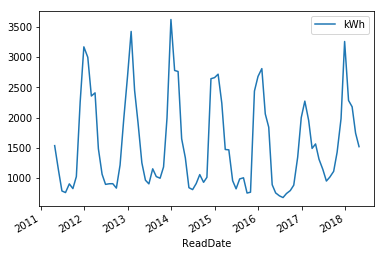

In [15]:
billing_df.plot()
plt.show()

### Weather Data

It is clear from the plot above that the electric energy consumption at this home has a trend in annual usage, with higher usage during the winter. Because usage appears to be temperature dependent we'll merge weather data from a nearby weather station to use in developing regression models.

In [16]:
weather_df = pd.read_csv('data/raw/weather data.csv', dtype=str)

In [17]:
weather_df.head()

STATION                STATION_NAME ELEVATION  LATITUDE   LONGITUDE  \
0  WBAN:94281  AURORA STATE AIRPORT OR US      59.7  45.24861  -122.76861   
1  WBAN:94281  AURORA STATE AIRPORT OR US      59.7  45.24861  -122.76861   
2  WBAN:94281  AURORA STATE AIRPORT OR US      59.7  45.24861  -122.76861   
3  WBAN:94281  AURORA STATE AIRPORT OR US      59.7  45.24861  -122.76861   
4  WBAN:94281  AURORA STATE AIRPORT OR US      59.7  45.24861  -122.76861   

               DATE REPORTTPYE HOURLYSKYCONDITIONS HOURLYVISIBILITY  \
0  2013-11-01 00:53      FM-15            OVC:08 9             4.00   
1  2013-11-01 01:53      FM-15            OVC:08 8             5.00   
2  2013-11-01 02:16      FM-16           OVC:08 10             5.00   
3  2013-11-01 02:50      FM-16   BKN:07 6 OVC:08 9             6.00   
4  2013-11-01 02:53      FM-15   BKN:07 6 OVC:08 9             6.00   

  HOURLYPRSENTWEATHERTYPE                ...                 \
0                 BR:1 ||                ...                  
1                 BR:1 ||                ...                  
2                 BR:1 ||                ...                  
3                 BR:1 ||                ...                  
4                 BR:1 ||                ...                  

  MonthlyMaxSeaLevelPressureTime MonthlyMinSeaLevelPressureValue  \
0                          -9999                             NaN   
1                          -9999                             NaN   
2                          -9999                             NaN   
3                          -9999                             NaN   
4                          -9999                             NaN   

  MonthlyMinSeaLevelPressureDate MonthlyMinSeaLevelPressureTime  \
0                          -9999                          -9999   
1                          -9999                          -9999   
2                          -9999                          -9999   
3                          -9999                          -9999   
4                          -9999                          -9999   

  MonthlyTotalHeatingDegreeDays MonthlyTotalCoolingDegreeDays  \
0                           NaN                           NaN   
1                           NaN                           NaN   
2                           NaN                           NaN   
3                           NaN                           NaN   
4                           NaN                           NaN   

  MonthlyDeptFromNormalHeatingDD MonthlyDeptFromNormalCoolingDD  \
0                            NaN                            NaN   
1                            NaN                            NaN   
2                            NaN                            NaN   
3                            NaN                            NaN   
4                            NaN                            NaN   

  MonthlyTotalSeasonToDateHeatingDD MonthlyTotalSeasonToDateCoolingDD  
0                               NaN                               NaN  
1                               NaN                               NaN  
2                               NaN                               NaN  
3                               NaN                               NaN  
4                               NaN                               NaN  

[5 rows x 90 columns]

Similar to the billing data, several cleaning/processing stepts are applied to the weather data. These include selecting relevant data, converting data types, setting an index, resapmling, and interploation.

In [18]:
weather_df = weather_df[
        ['HOURLYDRYBULBTEMPF', 'DATE']]
weather_df.columns = ['Temp', 'Date Time']
weather_df['Date Time'] = pd.to_datetime(weather_df['Date Time'])
# "suspect values" apper with an 's'
weather_df['Temp'] = weather_df['Temp'].str.replace('s', '')
weather_df['Temp'] = weather_df['Temp'].str.replace('*', '')
weather_df['Temp'] = weather_df['Temp'].apply(pd.to_numeric)
weather_df.set_index('Date Time', inplace=True)
weather_df = weather_df.resample('1Min').mean()
weather_df.interpolate(limit=61, inplace=True, limit_direction='both')
weather_df = weather_df.resample('H').mean()

In [19]:
weather_df.head()

Temp
Date Time                     
2013-11-01 00:00:00  50.050000
2013-11-01 01:00:00  50.602500
2013-11-01 02:00:00  51.297396
2013-11-01 03:00:00  49.435937
2013-11-01 04:00:00  48.397748

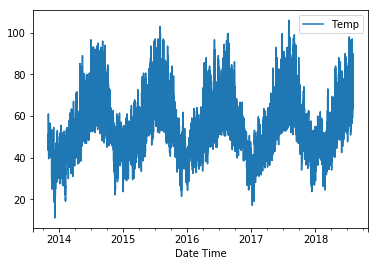

In [20]:
weather_df.plot()
plt.show()

One challenge in merging the billing and weather data is that the two datasets are sampled at different intervals, the billing data is monthly and the weather data is hourly. We use degree days to handle this problem because heating degree days (HDDs) and cooling degree days (CDDs) can be summed over any interval of time and still capture information about the temperature during that period.

In [21]:
hdd_base = 60
cdd_base = 70
hdd = hdd_base - weather_df['Temp']
cdd = weather_df['Temp'] - cdd_base
hdd = hdd[hdd > 0]
cdd = cdd[cdd > 0]
cdd = cdd / 24.0  # convert to degree days from degree hours
hdd = hdd / 24.0
cdd = cdd.resample('H').sum().fillna(0)
hdd = hdd.resample('H').sum().fillna(0)
weather_df['CDD'] = cdd
weather_df['HDD'] = hdd
weather_df['CDD'].fillna(0, inplace=True)
weather_df['HDD'].fillna(0, inplace=True)
del weather_df['Temp']

In [22]:
weather_df.head()  # data is still hourly

CDD       HDD
Date Time                         
2013-11-01 00:00:00  0.0  0.414583
2013-11-01 01:00:00  0.0  0.391563
2013-11-01 02:00:00  0.0  0.362609
2013-11-01 03:00:00  0.0  0.440169
2013-11-01 04:00:00  0.0  0.483427

### Merging Billing and Weather Data

This block of code creates a new data frame varaible "df" and steps through each interval of billing data to sum the HDDs, CDDs, and energy consumption, which is then appended to the new data frame.

In [23]:
billing_index = list(billing_df['kWh'].dropna().index)
billing_df = billing_df.resample('H').mean()
billing_df = pd.merge(
    billing_df, weather_df, how='outer', left_index=True, right_index=True)
df = pd.DataFrame(columns=billing_df.columns)
for start_index in billing_index[0:-1]:
    end_index = billing_index[billing_index.index(start_index) + 1]
    row = billing_df[
        (billing_df.index > start_index) & (billing_df.index <= end_index)].sum()
    df = df.append(pd.DataFrame(index=[end_index], data=[row.values], columns=row.index))

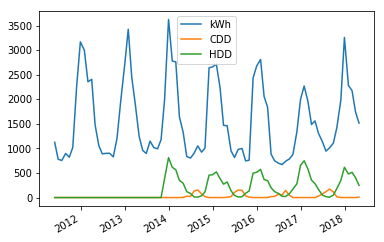

In [24]:
df.plot()
plt.show()

### Project Data

Project data contains fields like address, installation dates, preliminary estimates of energy savings, and many others. This example will only use the project installation date.

In [25]:
project_df = pd.read_csv('data/raw/project data.csv', dtype=str)

In [26]:
project_df.head()

ProjectId MeasureId                             et_siteID et_sitenumber  \
0  P00001111548   2862891  AD16A421-7FCF-E411-B4B1-00155D017F3F        411894   
1  P00001154641   3260621  F03524F9-F40A-E611-80D5-00155D010F47        683285   

  et_parentsiteId et_parentsitenumber         ProjectTitle  \
0             NaN                 NaN  69539 E Fairway Ave   
1             NaN                 NaN   12411 S New Era Rd   

      et_streetaddress      et_city et_state   ...   TStat_kwh KWH2010  \
0  69539 E Fairway Ave      Welches       OR   ...           0       0   
1   12411 S New Era Rd  Oregon City       OR   ...           0       0   

  KWH2011 KWH2012 KWH2013 KWH2014 KWH2015 KWH2016 KWH2017 KWH2018  
0     941       0     100       0       0       0       0       0  
1       0       0       0       0       0       0       0       0  

[2 rows x 95 columns]

Similar process of preparing and selecting data.

In [27]:
project_df = project_df[['et_sitenumber', 'InstalledDate']]
date_format = '%m/%d/%Y'
project_df['InstalledDate'] = pd.to_datetime(project_df['InstalledDate'], format=date_format)
project_df = project_df[project_df['et_sitenumber'] == site_number]
install_date = project_df['InstalledDate'].iloc[0]

In [28]:
install_date

Timestamp('2016-03-29 00:00:00')

### Combining Project Data with Billing and Weather Data

The installation date of the heat pump is used to split the billing and weather data into a pre-installation and post-installation period. Each period is limited to 12 months to that a full annual cycle of consumption is captured but usage patters from well before or after the installation are not.

In [29]:
import datetime as dt  # datetime is a python package for dealing with time stamps

In [30]:
pre_start = (install_date - dt.timedelta(365))
pre_end = df[df.index <= install_date].index[-1]
post_start = df[df.index >= install_date].index[0]
post_end = (post_start + dt.timedelta(365))
pre = df[((df.index > pre_start) & (df.index <= pre_end))]
post = df[((df.index >= post_start) & (df.index < post_end))][1:]

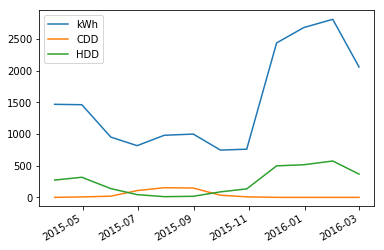

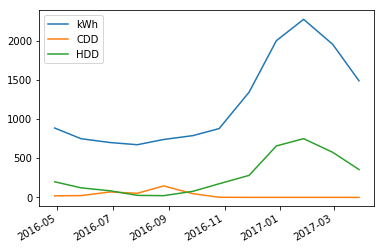

In [31]:
pre.plot()
post.plot()
plt.show()

## Visulization

All of the plots so far have been very simple, but for including images in reports we'll add more detail to the figures.

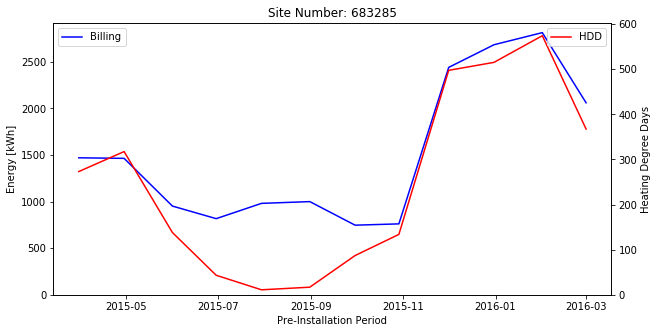

In [32]:
plt.close('all')
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()
ax1.plot(pre.index, pre.kWh, label='Billing', color='b')
ax2.plot(pre.index, pre.HDD, label='HDD', color='r')
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)
ax1.set_ylabel('Energy [kWh]')
ax2.set_ylabel('Heating Degree Days')
ax1.set_xlabel('Pre-Installation Period')
ax2.set_title('Site Number: ' + site_number)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

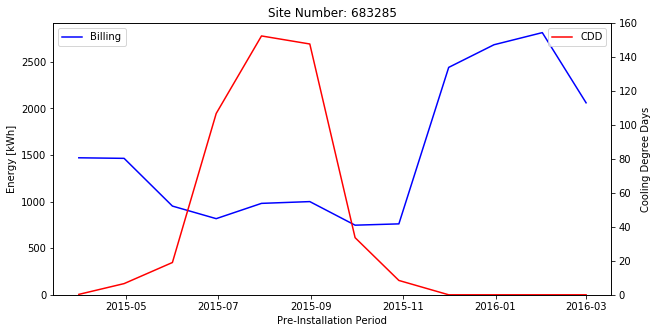

In [33]:
plt.close('all')
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()
ax1.plot(pre.index, pre.kWh, label='Billing', color='b')
ax2.plot(pre.index, pre.CDD, label='CDD', color='r')
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)
ax1.set_ylabel('Energy [kWh]')
ax2.set_ylabel('Cooling Degree Days')
ax1.set_xlabel('Pre-Installation Period')
ax2.set_title('Site Number: ' + site_number)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

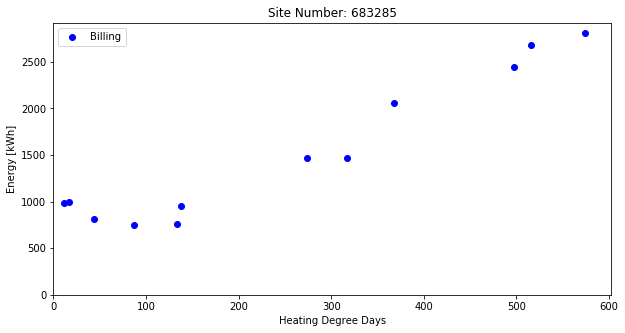

In [34]:
plt.close('all')
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.scatter(pre.HDD, pre.kWh, label='Billing', color='b')
ax1.set_ylim(bottom=0)
ax1.set_xlim(left=0)
ax1.set_ylabel('Energy [kWh]')
ax1.set_xlabel('Heating Degree Days')
ax1.set_title('Site Number: ' + site_number)
ax1.legend(loc='upper left')
plt.show()

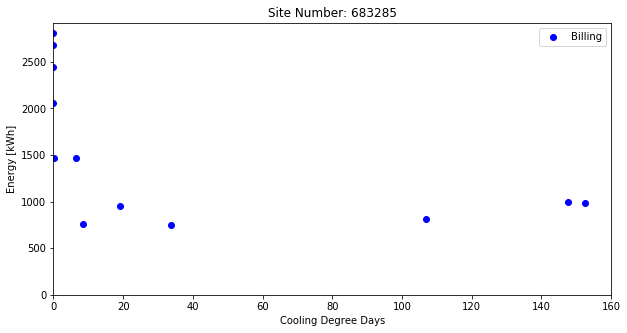

In [35]:
plt.close('all')
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.scatter(pre.CDD, pre.kWh, label='Billing', color='b')
ax1.set_ylim(bottom=0)
ax1.set_xlim(left=0)
ax1.set_ylabel('Energy [kWh]')
ax1.set_xlabel('Cooling Degree Days')
ax1.set_title('Site Number: ' + site_number)
ax1.legend(loc='upper right')
plt.show()

## Modeling

In [36]:
import statsmodels.formula.api as smf  # python package for linear regression

We use the pre-installation data as the baseline for post-installation consumption. Modeling energy usage as a function of HDDs and CDDs enables us to predict what post-installation consumption would have been had the heat pump not been installed. Taking the difference between these predictions and the measured consumption gives us an estimate of energy savings.

In [37]:
pre_measured_kwh = pre.iloc[:, 0].values
post_measured_kwh = post.iloc[:, 0].values
pre_model = smf.ols('kWh ~ HDD + CDD', data=pre).fit()
pre_predicted_kwh = pre_model.predict(exog=pre)
post_predicted_kwh = pre_model.predict(exog=post)

Merging measured and modeled values into a single data frame.

In [38]:
model_df = pd.DataFrame()
model_df = pd.merge(
    model_df,
    pd.Series(data=pre_measured_kwh, index=pre.index, name='pre_measured_kwh').to_frame(),
    left_index=True, right_index=True, how='outer')
model_df = pd.merge(
    model_df,
    pd.Series(
        data=pre_predicted_kwh, index=pre.index, name='pre_predicted_kwh').to_frame(),
    left_index=True, right_index=True, how='outer')
model_df = pd.merge(
    model_df,
    pd.Series(data=post_measured_kwh, index=post.index, name='post_measured_kwh').to_frame(),
    left_index=True, right_index=True, how='outer')
model_df = pd.merge(
    model_df,
    pd.Series(
        data=post_predicted_kwh, index=post.index, name='post_predicted_kwh').to_frame(),
    left_index=True, right_index=True, how='outer')

In [39]:
model_df.head()

pre_measured_kwh  pre_predicted_kwh  post_measured_kwh  \
2015-03-31            1470.0        1435.575580                NaN   
2015-04-30            1464.0        1678.108400                NaN   
2015-06-01             952.0         888.872387                NaN   
2015-06-30             817.0         885.530654                NaN   
2015-07-30             981.0         965.016258                NaN   

            post_predicted_kwh  
2015-03-31                 NaN  
2015-04-30                 NaN  
2015-06-01                 NaN  
2015-06-30                 NaN  
2015-07-30                 NaN

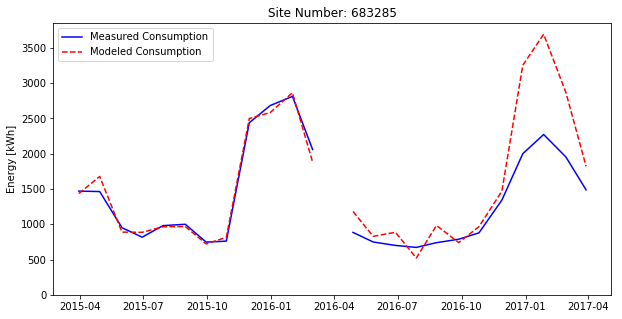

In [40]:
plt.close('all')
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(model_df.index, model_df.pre_measured_kwh, label='Measured Consumption', color='b', ls='-')
ax1.plot(model_df.index, model_df.pre_predicted_kwh, label='Modeled Consumption', color='r', ls='--')
ax1.plot(model_df.index, model_df.post_measured_kwh, label='_nolegend_', color='b', ls='-')
ax1.plot(model_df.index, model_df.post_predicted_kwh, label='_nolegend_', color='r', ls='--')
ax1.set_ylim(bottom=0)
ax1.set_ylabel('Energy [kWh]')
ax1.set_title('Site Number: ' + site_number)
ax1.legend(loc='upper left')
plt.show()

In [41]:
savings = post_predicted_kwh.sum() - post_measured_kwh.sum()
print ('Estimate of Annual Energy Savings: ' + str(int(savings)) + ' kWh')

Estimate of Annual Energy Savings: 4747 kWh


In [42]:
#model_df.to_csv('data/processed/' + site_number + '.csv')